In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from scipy.interpolate import interp1d
import sys
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib import cm
import plotly.graph_objects as go
from scipy.special import lpmv
import os

In [2]:
from math import factorial
def scipy_norm(l,m):
    return (1/(np.sqrt(2*np.pi)))*np.sqrt((2*l+1)/2*factorial(l-m)/factorial(l+m))

In [3]:
def check_endianness(filename):
  f=open(filename,'rb')
  #little endian
  version=np.fromfile(f,np.int32,count=1)[0]
  endian='l'
  if abs(version) > 100:
    f.close()
    f=open(filename,'rb')
    version=np.fromfile(f,'>i4',count=1)[0]
    endian='B'
  access='st'
  f.close()
  return version,endian,access

def read_stream_G(filename,endian):
  f=open(filename,'rb')
  fmt='>i4'
  version=np.fromfile(f,np.int32,count=1)[0]
  fmt='>S64'
  runID=np.fromfile(f, fmt, count=1)[0]
  time=np.fromfile(f,np.float32,count=1)[0]
  print("time from G files=",time)
  if version>13:
    ra,pr,axi,sc,ek,stef,prmag,radratio,sigma=np.fromfile(f,np.float32,count=9)
  else:
    ra,pr,axi,sc,ek,prmag,radratio,sigma=np.fromfile(f,np.float32,count=8)
    stef=0.0
  fmt='>i4'
  nr,ntheta,npi,minc,n_r_ic_max=np.fromfile(f,np.int32,count=5)
  if npi==2*ntheta:
    npi=int(npi/minc)
  nphi=npi*minc+1

  if version>13:
    l_heat,l_chem,l_phase,l_mag,l_press,l_cond_ic=np.fromfile(f,np.int32,count=6)
  else:
    l_heat,l_chem,l_mag,l_press,l_cond_ic=np.fromfile(f,np.int32,count=5)
    l_phase=False
  colatitude=np.fromfile(f,np.float32,ntheta)
  radius=np.fromfile(f,np.float32,nr)
  if(l_mag!=0 and n_r_ic_max>1):
    radius_ic=np.fromfile(f,np.float32,n_r_ic_max)

  vr=np.zeros((npi,ntheta,nr),np.float32)
  vtheta=np.zeros_like(vr)
  vphi=np.zeros_like(vr)
  if l_heat!=0:
    entropy=np.zeros_like(vr)
  if l_press!=0:
    pre=np.zeros_like(vr)


    #outer core
  for i in range(nr):
    dat=np.fromfile(f,np.float32,count=ntheta*npi)
    vr[:,:,i]=dat.reshape(npi,ntheta)
    dat=np.fromfile(f,np.float32,count=ntheta*npi)
    vtheta[:,:,i]=dat.reshape(npi,ntheta)
    dat=np.fromfile(f,np.float32,count=ntheta*npi)
    vphi[:,:,i]=dat.reshape(npi,ntheta)
    if l_heat!=0:
      dat=np.fromfile(f,np.float32,count=ntheta*npi)
      entropy[:,:,i]=dat.reshape(npi,ntheta)
    if l_press!=0:
      dat=np.fromfile(f,np.float32,count=ntheta*npi)
      pre[:,:,i]=dat.reshape(npi,ntheta)
  radius_rev=radius[...,::-1]
  vr_rev=vr[...,::-1]
  vtheta_rev=vtheta[...,::-1]
  vphi_rev=vphi[...,::-1]
  entropy_rev=entropy[...,::-1]
  radius_rev=radius[::-1]

  f.close()
  #list_1=[version,runID]
  #list_2=[time,ra,pr,axi,sc,ek,stef,prmag,radratio,sigma]
  #list_3=[nr,ntheta,nphi,minc,n_r_ic_max]
  #list_4=[l_heat,l_chem,l_phase,l_mag,l_press,l_cond_ic]
  #list_5=[colatitude,radius]
  list_geo=[radius_rev,nphi,ntheta,nr]
  list_vel=[vr_rev,vtheta_rev,vphi_rev,entropy_rev]
  #list_6=[entropy,pre]
  return list_vel,list_geo,minc

In [4]:
def read_stream(filename):
    f=open(filename,'rb')
    version=np.fromfile(f,np.int32,count=1)[0]#read the version
    time,Ra,Pr,Raxi,Sc,Prmag,Ek,radratio,sigma_ratio=np.fromfile(f,np.float32,count=9)#read the parameters
    print("time from potential file=",time)
    n_r_max,n_r_ic_max,l_max,minc,lm_max=np.fromfile(f,np.int32,count=5)
    m_min,m_max=np.fromfile(f,"{}2i4".format('<'),count=1)[0]
    omega_ic,omega_max=np.fromfile(f,np.float32,count=2)#rotation
    radius=np.fromfile(f,"{}{}f4".format('<',n_r_max),count=1)[0]#radius
    radius=radius[::-1]
    rho=np.fromfile(f,"{}{}f4".format('<',n_r_max),count=1)[0]#background density
    pol=np.fromfile(f,"{}({},{})c8".format('<',n_r_max,lm_max),count=1)[0]#poloidal potential
    pol=pol.T
    tor=np.fromfile(f,"{}({},{})c8".format('<',n_r_max,lm_max),count=1)[0]#toroidal potential
    tor=tor.T
    params=[time,Ra,Pr,Raxi,Sc,Prmag,Ek,radratio,sigma_ratio]
    rad_sph_params=[n_r_max,n_r_ic_max,l_max,minc,lm_max,m_max,m_min]
    omega=[omega_ic,omega_max]
    rad=[radius]
    rho_list=[rho]
    potentials=[pol,tor]
    return version,params,rad_sph_params,omega,rad,rho_list,potentials

In [5]:
def read_stream(filename):
    f=open(filename,'rb')
    version=np.fromfile(f,np.int32,count=1)[0]#read the version
    time,Ra,Pr,Raxi,Sc,Prmag,Ek,radratio,sigma_ratio=np.fromfile(f,np.float32,count=9)#read the parameters
    print("time from potential file=",time)
    n_r_max,n_r_ic_max,l_max,minc,lm_max=np.fromfile(f,np.int32,count=5)
    m_min,m_max=np.fromfile(f,"{}2i4".format('<'),count=1)[0]
    omega_ic,omega_max=np.fromfile(f,np.float32,count=2)#rotation
    radius=np.fromfile(f,"{}{}f4".format('<',n_r_max),count=1)[0]#radius
    radius=radius[::-1]
    rho=np.fromfile(f,"{}{}f4".format('<',n_r_max),count=1)[0]#background density
    pol=np.fromfile(f,"{}({},{})c8".format('<',n_r_max,lm_max),count=1)[0]#poloidal potential
    pol=pol.T
    tor=np.fromfile(f,"{}({},{})c8".format('<',n_r_max,lm_max),count=1)[0]#toroidal potential
    tor=tor.T
    params=[time,Ra,Pr,Raxi,Sc,Prmag,Ek,radratio,sigma_ratio]
    rad_sph_params=[n_r_max,n_r_ic_max,l_max,minc,lm_max,m_max,m_min]
    omega=[omega_ic,omega_max]
    rad=[radius]
    rho_list=[rho]
    potentials=[pol,tor]
    return version,params,rad_sph_params,omega,rad,rho_list,potentials

def chebgrid(nr,a,b):#will look back at this if it really produces chebyshev grids
    rst=(a+b)/(b-a)
    rr=0.5*(rst+np.cos(np.pi*(1.-np.arange(nr+1.)/nr)))*(b-a)# /nr here
    return rr

def ff(i,nr):
    if i==0:
        return 0
    ff=float(nr)*0.5/np.tan(np.pi*float(i)/float(2.0*nr))

    a=i%2
    if a==0:
        ff=-ff
    return ff

def dnum(k,j,nr):
    if k==0:
        if(j==0 or j==nr):
            dnum=0.5
            a=nr%2
            if a==1:
                dnum=-dnum
            if j==0:
                dnum=1.0/3.0*float(nr*nr)+1.0/6.0
            return dnum
        dnum=0.5*(float(nr)+0.5)*((float(nr)+0.5)+(1.0/np.tan(np.pi*float(j)\
             /float(2.0*nr)))**2)+1.0/8.0-0.25/(np.sin(np.pi*float(j)/ \
             float(2*nr))**2)-0.5*float(nr*nr)
        return dnum
    dnum=ff(k+j,nr)+ff(k-j,nr)
    return dnum

def den(k,j,nr):
    if k==0:
        den=0.5*float(nr)
        a=j%2
        if a==1:
            den=-den
        if(j==0 or j==nr):
            den=1.0
        return den
    den=float(nr)*np.sin(np.pi*float(k)/float(nr))
    if(j==0 or j==nr):
        den=2.0*den
    return den

def spdel(kr,jr,nr,zl):
    if kr!=nr:
        fac=1
        k=kr
        j=jr
    else:
        fac=-1.0
        k=0.0
        j=nr-jr
    spdel=fac*dnum(k,j,nr)/den(k,j,nr)
    return -spdel*(2.0/zl)

def matder(nr,z1,z2):
    print("inside matder")
    nrp=nr+1
    w1=np.zeros((nrp,nrp),dtype=np.float64)
    zl=z2-z1
    for i in range(nrp):
        for j in range(nrp):
            w1[i,j]=spdel(i,j,nr,zl)           
    return w1

def rderavg(data,rad,exclude=False):
    r1=rad[0]
    r2=rad[-1]
    nr=data.shape[-1]
    grid=chebgrid(nr-1,r1,r2)
    tol=1e-6
    diff=abs(grid-rad).max()
    if diff>tol:
        spectral=False
        grid=rad
    else:
        spectral=True
    if spectral:
        d1=matder(nr-1,r1,r2)
        if (data.shape)==1:
            der=np.dot(d1,data)
        elif len(data.shape)==2:
            der=np.tensordot(data,d1,axes=[1,1])
        else:
            der=np.tensordot(data,d1,axes=[2,1])
    else:
        print("rederavg spectral = false")
        denom=np.roll(grid,-1)-np.roll(grid,1)
        denom[0]=grid[1]-grid[0]
        denom[-1]=grid[-1]-grid[-2]
        der=(np.roll(data,-1,axis=-1)-np.roll(data,1,axis=-1))/denom
        der[...,0]=(data[...,1]-data[...,0])/(grid[1]-grid[0])
        der[...,-1]=(data[...,-1]-data[...,-2])/(grid[-1]-grid[-2])
    return der

def area_avg(data,phi,theta):
    sum=0.0
    dtheta,dphi=theta[1]-theta[0],phi[1]-phi[0]
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            sum+=data[i,j]*np.sin(theta[i])*dtheta*dphi
    sum=(sum)/(4*np.pi)
    return sum

In [6]:
class Legendre:
  def __init__(self,l_max,minc,n_theta_max,m_max,m_min):#initialize function
    self.l_max=l_max#maximum degree of expansion
    self.m_max=m_max#maximum azimuthal mode
    self.minc=minc#azimuthal symmetry
    self.n_theta_max=n_theta_max
    self.n_m_max=m_max//minc+1# Eg: m_max=96 => n_m_max=96//2+1=49
    self.n_phi_max=n_theta_max*2//2
    self.m_min=m_min#included m_min earlier we excluded this

    self.get_index,self.offsets,self.lm_max=self._build_index_map()#called all of them itself here as class objects rather than in main routine
    self.idx,self.lm2l,self.lm2m=self._LMmapping()
    self.LM_list=self._getLM(self.idx)
    self.lStart,self.lStop,self.lmOdd=self._getblocks()

    #declare arrays
    self.Plm=np.zeros((self.lm_max,self.n_theta_max//2))    #P_l^m(cos(theta))
    self.wPlm=np.zeros_like(self.Plm)   #weighted P_l^m
    self.wdPlm=np.zeros_like(self.Plm)  #weighted derivative
    self.dPlm=np.zeros_like(self.Plm)   #derivative wrt theta
    self.dPhi=np.zeros_like(self.Plm)   #derivative wrt phi
    self.sinTh=np.zeros(n_theta_max)  #sin(theta) values
    self.gauss=np.zeros(n_theta_max)  #gauss-legendre polynomial

    #theta and weights
    self.theta_ord,self.gauss=self._gauleg(self.n_theta_max)

    dpi=np.pi

    for ntheta in range(self.n_theta_max//2):
      colat=self.theta_ord[ntheta]
      plma,dtheta_plma=self._plm_theta(colat)
      lm=0
      for m in range(0,self.m_max+1,self.minc):
        for l in range(m,self.l_max+1):
          self.Plm[lm,ntheta]=((-1.0)**m)*plma[lm]
          self.dPlm[lm,ntheta]=((-1.0)**m)*dtheta_plma[lm]/(np.sin(colat))
          self.dPhi[lm,ntheta]=m/(np.sin(colat))
          self.wPlm[lm,ntheta]=2.0*dpi*self.gauss[ntheta]*self.Plm[lm,ntheta]
          self.wdPlm[lm,ntheta]=2.0*dpi*self.gauss[ntheta]*self.dPlm[lm,ntheta]
          lm+=1


  def _build_index_map(self):#previously it took m_max and minc as arguments
    m_values=list(range(0,self.m_max+1,self.minc))
    offsets={}
    idx=0
    for m in m_values:
      offsets[m]=idx
      idx+=(l_max-m+1)
    total=idx
    def get_index(m,l):
      return offsets[m]+(l-m)
    return get_index,offsets,total

  def _LMmapping(self):
    idx=np.zeros((self.l_max+1,self.m_max+1),np.int32)
    lm2l=np.zeros(self.lm_max,np.int16)
    lm2m=np.zeros(self.lm_max,np.int16)
    k=0
    for m in range(self.m_min,self.m_max+1,self.minc):#earlier the last slot was 0 as loop was only upto m_max
      for l in range(m,self.l_max+1):
        idx[l,m]=k
        lm2l[k]=l
        lm2m[k]=m
        k+=1
    return idx,lm2l,lm2m

  def _getLM(self,idx):
    LM_list=[]
    for m in range(self.m_min,self.m_max+1,self.minc):
      for l in range(m,self.l_max+1):
        LM_list.append(idx[l,m])
    LM_list=np.array(LM_list)
    return LM_list# the last entry is lm_max-1 as python idexing starts from 0

  def _getblocks(self):#start and end index of each m block, the first block m=0 has all l and last will have only 1
    lStart=np.zeros(self.n_m_max,dtype=int)
    lStop=np.zeros(self.n_m_max,dtype=int)
    lmOdd=np.zeros(self.n_m_max,dtype=int)

    lStart[0]=0#lStart[0]=1
    lStop[0]=self.l_max#lStop[0]=l_max+1
    lmOdd[0]=(self.l_max%2==0)

    for mc in range(1,self.n_m_max):
      m=mc*self.minc
      lStart[mc]=lStop[mc-1]+1
      lStop[mc]=lStart[mc]+(self.l_max-m)
      lmOdd[mc]=((lStop[mc]-lStart[mc])%2==0)

    return lStart,lStop,lmOdd
      
  def _specfilter(self,lcut=None,mcut=None):
      mask=np.ones(self.lm_max,dtype=bool)
      if lcut is not None:
          mask&=(self.lm2l==lcut)
      if mcut is not None:
          mask&=(self.lm2m==mcut)
      return mask
      
  def _spectraavgl(self,radius,poloidal,toroidal):
      return 0

  def _spectra(self,radius,radial_level,poloidal,toroidal,lspec,mspec):
      dpoldr=np.zeros_like(poloidal)
      dpoldr=rderavg(poloidal,radius,False)
      inputLM=np.zeros_like(poloidal)
      for i in range(radius.shape[0]):
          inputLM[:,i]=poloidal[:,i]*self.lm2l*(self.lm2l+1)/radius[i]**2
      m_list,l_list=[],[]
      Eltot,Elphi,Elthe,Elrad=[],[],[],[]
      Emtot,Emphi,Emthe,Emrad=[],[],[],[]
      if radial_level=='outer':
          spec_inputLM,spec_dpoldr,spec_toroidal=inputLM[:,-1],dpoldr[:,-1],toroidal[:,-1]
      if radial_level=='inner':
          spec_inputLM,spec_dpoldr,spec_toroidal=inputLM[:,0],dpoldr[:,0],toroidal[:,0]
      
      if lspec is not None:
          for l in range(0,self.l_max):
              mask=self._specfilter(l,None)
              dpoldr_masked,toroidal_masked,inputLM_masked=spec_dpoldr*mask,spec_toroidal*mask,spec_inputLM*mask
              vt,vp=self._specspat_vec(dpoldr_masked,toroidal_masked,self.n_theta_max,self.n_phi_max)
              vt=np.fft.ifft(vt,axis=0)*self.n_phi_max
              vp=np.fft.ifft(vp,axis=0)*self.n_phi_max
              vt,vp=vt.real,vp.real
              vt,vp=vt.T,vp.T
              vr=self._specspat_scal(inputLM_masked,self.n_theta_max,self.n_phi_max)
              vr=np.fft.ifft(vr,axis=0)*self.n_phi_max
              vr=vr.real
              vr=vr.T
              vt,vp,vr=np.tile(vt,(1,2)),np.tile(vp,(1,2)),np.tile(vr,(1,2))
              nlon,nlat=vt.shape[1],vt.shape[0]
              phi_plot,theta_plot=np.linspace(0,leg.minc*np.pi,nlon),np.linspace(0,np.pi,nlat)
              v2=vp**2/16+vt**2/16+vr**2
              val_out=area_avg(v2,phi_plot,theta_plot)
              Eltot.append(val_out)
              val_out=area_avg(vp**2/16,phi_plot,theta_plot)
              Elphi.append(val_out)
              val_out=area_avg(vt**2/16,phi_plot,theta_plot)
              Elthe.append(val_out)
              val_out=area_avg(vr**2,phi_plot,theta_plot)
              Elrad.append(val_out)
              l_list.append(l)
          return l_list,Eltot,Elphi,Elthe,Elrad
      if mspec is not None:
          for m in range(self.m_min,self.m_max,self.minc):
              mask=self._specfilter(None,m)
              dpoldr_masked,toroidal_masked,inputLM_masked=spec_dpoldr*mask,spec_toroidal*mask,spec_inputLM*mask
              vt,vp=self._specspat_vec(dpoldr_masked,toroidal_masked,self.n_theta_max,self.n_phi_max)
              vt=np.fft.ifft(vt,axis=0)*self.n_phi_max
              vp=np.fft.ifft(vp,axis=0)*self.n_phi_max
              vt,vp=vt.real,vp.real
              vt,vp=vt.T,vp.T
              vr=self._specspat_scal(inputLM_masked,self.n_theta_max,self.n_phi_max)
              vr=np.fft.ifft(vr,axis=0)*self.n_phi_max
              vr=vr.real
              vr=vr.T
              vt,vp,vr=np.tile(vt,(1,2)),np.tile(vp,(1,2)),np.tile(vr,(1,2))
              nlon,nlat=vt.shape[1],vt.shape[0]
              phi_plot,theta_plot=np.linspace(0,leg.minc*np.pi,nlon),np.linspace(0,np.pi,nlat)
              v2=vp**2/16+vt**2/16+vr**2
              val_out=area_avg(v2,phi_plot,theta_plot)
              Emtot.append(val_out)
              val_out=area_avg(vp**2/16,phi_plot,theta_plot)
              Emphi.append(val_out)
              val_out=area_avg(vt**2/16,phi_plot,theta_plot)
              Emthe.append(val_out)
              val_out=area_avg(vr**2,phi_plot,theta_plot)
              Emrad.append(val_out)
              m_list.append(m)
          return m_list,Emtot,Emphi,Emthe,Emrad
              

  def _gauleg(self,n_theta_max):
    theta_ord=np.zeros(n_theta_max)
    gauss=np.zeros(n_theta_max)

    dpi=np.pi
    M=(n_theta_max+1)//2
    XXM=0.0
    XXL=1.0
    eps=3e-14

    for i in range(1,M+1):
      zz=np.cos(dpi*((i-0.25)/(n_theta_max+0.5)))
      zz1=0.0

      while abs(zz-zz1)>eps:
        p1=1.0
        p2=0.0
        for j in range(1,n_theta_max+1):
          p3=p2
          p2=p1
          p1=((2*j-1)*zz*p2-(j-1)*p3)/j
        pp=n_theta_max*(zz*p1-p2)/(zz*zz-1.0)
        zz1=zz
        zz=zz1-p1/pp

      theta_ord[i-1]=np.arccos(XXM+XXL*zz)
      theta_ord[n_theta_max-i]=np.arccos(XXM-XXL*zz)
      w=2.0*XXL/((1.0-zz**2)*pp**2)
      gauss[i-1]=w
      gauss[n_theta_max-i]=w

    return theta_ord,gauss

  def _plm_theta(self,theta):#see notes for derivation of the recurrence relation
    m_values=list(range(self.m_min,self.m_max+1,self.minc))#produces m_values and ndim_req produces
    ndim_req=sum((self.l_max-m+1) for m in m_values)#same output as previous LM routines

    plma=np.zeros(ndim_req,dtype=np.float64)
    dtheta_plma=np.zeros(ndim_req,dtype=np.float64)

    dnorm=1.0/np.sqrt(16.0*np.atan(1.0))#need to know why this is multiplied and how it is linked to derivation
    pos=-1

    for m in m_values:
      fac=1.0
      for j in range(3,2*m+2,2):#this section computes P^m_m for recurrence to buid higher P^m_m+1,P^m_m+2....P^m_lmax
        fac*=float(j)/float(j-1)
      plm0=np.sqrt(fac)
      s=np.sin(theta)
      if abs(s)>0.0:
        plm0=plm0*((-s)**m)
      elif m!=0:
        plm0=0.0

      l=m
      pos+=1
      plma[pos]=dnorm*plm0
      plm1=0.0

      for l in range(m+1,self.l_max+1):
        plm2=plm1#for l=m second term becomes zeros and hence recurrence remains consistent
        plm1=plm0
        num1=(2*l-1)*(2*l+1)
        den1=(l-m)*(l+m)
        term1=np.cos(theta)*np.sqrt(float(num1)/float(den1))*plm1
        num2=(2*l+1)*(l+m-1)*(l-m-1)
        den2=(2*l-3)*(l-m)*(l+m)
        term2=np.sqrt(float(num2)/float(den2))*plm2 if (den2!=0) else 0
        plm0=term1-term2
        pos+=1
        plma[pos]=dnorm*plm0

      l=self.l_max+1
      plm2=plm1
      plm1=plm0
      num1=(2*l-1)*(2*l+1)
      den1=(l-m)*(l+m)
      term1=np.cos(theta)*np.sqrt(float(num1)/float(den1))*plm1
      num2=(2*l+1)*(l+m-1)*(l-m-1)
      den2=(2*l-3)*(l-m)*(l+m)
      term2=np.sqrt(float(num2)/float(den2))*plm2
      plm0=term1-term2
      dtheta_plma[pos]=dnorm*plm0

    pos=-1
    for m in m_values:
      l=m
      pos+=1
      if m<self.l_max:
        dtheta_plma[pos]=(l/np.sqrt(float(2*l+3)))*plma[pos+1]
      else:
        dtheta_plma[pos]=(l/np.sqrt(float(2*l+3)))*plma[pos]

      for l in range(m+1,self.l_max):
        pos+=1
        termA=l*np.sqrt(float((l+m+1)*(l-m+1))/float((2*l+1)*(2*l+3)))*plma[pos+1]
        termB=(l+1)*np.sqrt(float((l+m)*(l-m))/float((2*l-1)*(2*l+1)))*plma[pos-1]
        dtheta_plma[pos]=termA-termB

      if m<self.l_max:
        l=self.l_max
        pos+=1
        termA=l*np.sqrt(float((l+m+1)*(l-m+1))/float((2*l+1)*(2*l+3)))*dtheta_plma[pos]
        termB=(l+1)*np.sqrt(float((l+m)*(l-m))/float((2*l-1)*(2*l+1)))*plma[pos-1]
        dtheta_plma[pos]=termA-termB

    return plma,dtheta_plma
      
  def _specspat_vec(self,dpoldr_LM,tor_LM,nth,nph):
      ii=1j
      lm_max=len(dpoldr_LM)

      PlmG=np.zeros(lm_max,dtype=np.float64)
      PlmC=np.zeros(lm_max,dtype=np.float64)
      vhG=np.zeros(lm_max,dtype=np.complex128)
      vhC=np.zeros(lm_max,dtype=np.complex128)

      vt=np.zeros((nph,nth),dtype=np.complex128)
      vp=np.zeros((nph,nth),dtype=np.complex128)

      vhG[:]=dpoldr_LM-ii*tor_LM
      vhC[:]=dpoldr_LM+ii*tor_LM

      dPlm,dPhi,Plm=self.dPlm,self.dPhi,self.Plm

      nThetaNHS=0
      for nThetaN in range(nth//2):
          nThetaS=nth-nThetaN-1
          for n_m in range(self.n_m_max):
              lms=self.lStop[n_m]
              for lm in range(self.lStart[n_m],lms-1,2):
                  PlmG[lm]=dPlm[lm,nThetaNHS]-dPhi[lm,nThetaNHS]*Plm[lm,nThetaNHS]
                  PlmC[lm]=dPlm[lm,nThetaNHS]+dPhi[lm,nThetaNHS]*Plm[lm,nThetaNHS]
                  PlmG[lm+1]=dPlm[lm+1,nThetaNHS]-dPhi[lm+1,nThetaNHS]*Plm[lm+1,nThetaNHS]
                  PlmC[lm+1]=dPlm[lm+1,nThetaNHS]+dPhi[lm+1,nThetaNHS]*Plm[lm+1,nThetaNHS]
              if self.lmOdd[n_m]:
                  PlmG[lms]=dPlm[lms,nThetaNHS]-dPhi[lms,nThetaNHS]*Plm[lms,nThetaNHS]
                  PlmC[lms]=dPlm[lms,nThetaNHS]+dPhi[lms,nThetaNHS]*Plm[lms,nThetaNHS]
           
          for n_m in range(self.n_m_max):
              lms=self.lStop[n_m]
              vhN1,vhS1,vhN2,vhS2=0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
              for lm in range(self.lStart[n_m],lms-1,2):
                  vhN1+=vhG[lm]*PlmG[lm]+vhG[lm+1]*PlmG[lm+1]
                  vhS1+=-vhG[lm]*PlmC[lm]+vhG[lm+1]*PlmC[lm+1]
                  vhN2+=vhC[lm]*PlmC[lm]+vhC[lm+1]*PlmC[lm+1]
                  vhS2+=-vhC[lm]*PlmG[lm]+vhC[lm+1]*PlmG[lm+1]

              if self.lmOdd[n_m]:
                  vhN1+=vhG[lms]*PlmG[lms]
                  vhS1-=vhG[lms]*PlmC[lms]
                  vhN2+=vhC[lms]*PlmC[lms]
                  vhS2-=vhC[lms]*PlmG[lms]

              vt[n_m,nThetaN]=0.5*(vhN1+vhN2)
              vt[n_m,nThetaS]=0.5*(vhS1+vhS2)
              vp[n_m,nThetaN]=-0.5*ii*(vhN1-vhN2)
              vp[n_m,nThetaS]=-0.5*ii*(vhS1-vhS2)
              
          nThetaNHS+=1
          
      if self.n_phi_max>1:
          vt[self.n_m_max:self.n_phi_max//2+1,:]=0.0
          vp[self.n_m_max:self.n_phi_max//2+1,:]=0.0
          for nThetaN in range(self.n_theta_max):
              for n_m in range(self.n_phi_max//2+1,self.n_phi_max):
                  vt[n_m,nThetaN]=np.conj(vt[self.n_phi_max-n_m,nThetaN])
                  vp[n_m,nThetaN]=np.conj(vp[self.n_phi_max-n_m,nThetaN])       
      return vt,vp
      
  def _specspat_scal(self,pol,nth,nph):
      ii=1j
      vr=np.zeros((nph,nth),dtype=np.complex128)
      n_m_max_loc=1 if nph==1 else self.n_m_max
      Plm=self.Plm
      for nThetaN in range(nth//2):
          nThetaS=nth-nThetaN-1
          for n_m in range(self.n_m_max):
              lms=self.lStop[n_m]
              s12=0.0+0.0j
              z12=0.0+0.0j
              for lm in range(self.lStart[n_m],lms-1,2):
                  s12+=pol[lm]*Plm[lm,nThetaN]
                  z12+=pol[lm+1]*Plm[lm+1,nThetaN]
              if self.lmOdd[n_m]:
                  s12+=pol[lms]*Plm[lms,nThetaN]
              vr[n_m,nThetaN]=s12+z12
              vr[n_m,nThetaS]=s12-z12

      if nph>1:
          vr[n_m_max_loc:nph//2+1,:]=0.0
          for nThetaN in range(nth):
              for n_m in range(nph//2+1,nph):
                  vr[n_m,nThetaN]=np.conj(vr[nph-n_m,nThetaN])
      
      return vr





#testing the LM indexing

In [7]:
version,params,rad_sph_params,omega,rad,rho_list,potentials=read_stream('V_lmr_1000.test_BIS')
l_max,minc,m_max,m_min=rad_sph_params[2],rad_sph_params[3],rad_sph_params[5],rad_sph_params[6]
#print("l_max=",l_max,"\n minc=",minc,"\n m_max=",m_max,"\n m_min=",m_min)
leg=Legendre(l_max,minc,144,m_max,m_min)
get_index,offsets,total=leg._build_index_map()
print("offsets=",offsets,"\n total=",total,"\n get_index=",get_index(42,48))
idx,lm2l,lm2m=leg._LMmapping()
print("lm2l=",lm2l,"\t shape=",lm2l.shape,"\n lm2m=",lm2m,"\t shape=",lm2m.shape)
LM_list=leg._getLM(idx)
print("LM list=",LM_list,"\t shape=",LM_list.shape)
lStart,lStop,lmOdd=leg._getblocks()
print("lStart =",lStart,"\t shape=",lStart.shape,"\n lStop=",lStop,"\t shape=",lStop.shape,"\n lmOdd=",lmOdd,"\t shape=",lmOdd.shape)

time from potential file= 0.9499
offsets= {0: 0, 2: np.int32(97), 4: np.int32(192), 6: np.int32(285), 8: np.int32(376), 10: np.int32(465), 12: np.int32(552), 14: np.int32(637), 16: np.int32(720), 18: np.int32(801), 20: np.int32(880), 22: np.int32(957), 24: np.int32(1032), 26: np.int32(1105), 28: np.int32(1176), 30: np.int32(1245), 32: np.int32(1312), 34: np.int32(1377), 36: np.int32(1440), 38: np.int32(1501), 40: np.int32(1560), 42: np.int32(1617), 44: np.int32(1672), 46: np.int32(1725), 48: np.int32(1776), 50: np.int32(1825), 52: np.int32(1872), 54: np.int32(1917), 56: np.int32(1960), 58: np.int32(2001), 60: np.int32(2040), 62: np.int32(2077), 64: np.int32(2112), 66: np.int32(2145), 68: np.int32(2176), 70: np.int32(2205), 72: np.int32(2232), 74: np.int32(2257), 76: np.int32(2280), 78: np.int32(2301), 80: np.int32(2320), 82: np.int32(2337), 84: np.int32(2352), 86: np.int32(2365), 88: np.int32(2376), 90: np.int32(2385), 92: np.int32(2392), 94: np.int32(2397), 96: np.int32(2400)} 
 total

In [8]:
print("offsets=",leg.offsets,"\n total=",leg.lm_max,"\n get_index=",leg.get_index(42,48))
print("lm2l=",leg.lm2l,"\t shape=",leg.lm2l.shape,"\n lm2m=",leg.lm2m,"\t shape=",leg.lm2m.shape)
print("LM list=",leg.LM_list,"\t shape=",leg.LM_list.shape)
print("lStart =",leg.lStart,"\t shape=",leg.lStart.shape,"\n lStop=",leg.lStop,"\t shape=",leg.lStop.shape,"\n lmOdd=",leg.lmOdd,"\t shape=",leg.lmOdd.shape)

offsets= {0: 0, 2: np.int32(97), 4: np.int32(192), 6: np.int32(285), 8: np.int32(376), 10: np.int32(465), 12: np.int32(552), 14: np.int32(637), 16: np.int32(720), 18: np.int32(801), 20: np.int32(880), 22: np.int32(957), 24: np.int32(1032), 26: np.int32(1105), 28: np.int32(1176), 30: np.int32(1245), 32: np.int32(1312), 34: np.int32(1377), 36: np.int32(1440), 38: np.int32(1501), 40: np.int32(1560), 42: np.int32(1617), 44: np.int32(1672), 46: np.int32(1725), 48: np.int32(1776), 50: np.int32(1825), 52: np.int32(1872), 54: np.int32(1917), 56: np.int32(1960), 58: np.int32(2001), 60: np.int32(2040), 62: np.int32(2077), 64: np.int32(2112), 66: np.int32(2145), 68: np.int32(2176), 70: np.int32(2205), 72: np.int32(2232), 74: np.int32(2257), 76: np.int32(2280), 78: np.int32(2301), 80: np.int32(2320), 82: np.int32(2337), 84: np.int32(2352), 86: np.int32(2365), 88: np.int32(2376), 90: np.int32(2385), 92: np.int32(2392), 94: np.int32(2397), 96: np.int32(2400)} 
 total= 2401 
 get_index= 1623
lm2l= [ 

#testing Legendre relations

In [9]:
#m_values,ndim_req=leg._plm_theta(0.01)
#print("m values =",m_values,"\t shape =",len(m_values),"\n ndim_req =",ndim_req)
l_max,m_max,minc,m_min=6,5,1,0
n_theta=250
leg=Legendre(l_max,minc,144,m_max,m_min)
#print(leg.theta_ord)
x=np.cos(leg.theta_ord)
w=leg.gauss
for k in [0,2,4,6]:
  exact=2.0/(k+1) if k%2==0 else 0.0
  approx=np.sum(w*x**k)
  print(f"k={k}: exact={exact:.6e}, approx={approx:.6e}, error={abs(exact-approx):.2e}")

thet=leg.theta_ord[0]#take theta=0
plma,dtheta_pma=leg._plm_theta(thet)

print("Comparison at theta=%.3f (radians)"%thet)
pos=-1
for m in range(m_max+1):
  for l in range(m,l_max+1):
    pos+=1
    norms=scipy_norm(l,m)
    x=np.cos(thet)
    scipy_val=norms*lpmv(m,l,x)
    our_val=plma[pos]
    print(f"(l={l}, m={m}): scipy={scipy_val:.6e}, ours={our_val:.6e}, ratio={our_val/(scipy_val+1e-30):.6e}")

k=0: exact=2.000000e+00, approx=2.000000e+00, error=8.26e-14
k=2: exact=6.666667e-01, approx=6.666667e-01, error=8.23e-14
k=4: exact=4.000000e-01, approx=4.000000e-01, error=8.19e-14
k=6: exact=2.857143e-01, approx=2.857143e-01, error=8.16e-14
Comparison at theta=0.017 (radians)
(l=0, m=0): scipy=2.820948e-01, ours=2.820948e-01, ratio=1.000000e+00
(l=1, m=0): scipy=4.885348e-01, ours=4.885348e-01, ratio=1.000000e+00
(l=2, m=0): scipy=6.305211e-01, ours=6.305211e-01, ratio=1.000000e+00
(l=3, m=0): scipy=7.457326e-01, ours=7.457326e-01, ratio=1.000000e+00
(l=4, m=0): scipy=8.451128e-01, ours=8.451128e-01, ratio=1.000000e+00
(l=5, m=0): scipy=9.336601e-01, ours=9.336601e-01, ratio=1.000000e+00
(l=6, m=0): scipy=1.014151e+00, ours=1.014151e+00, ratio=1.000000e+00
(l=1, m=1): scipy=-5.749572e-03, ours=-5.749572e-03, ratio=1.000000e+00
(l=2, m=1): scipy=-1.285465e-02, ours=-1.285465e-02, ratio=1.000000e+00
(l=3, m=1): scipy=-2.150548e-02, ours=-2.150548e-02, ratio=1.000000e+00
(l=4, m=1): sc

In [10]:
#pairs=[(0,0),(1,0),(1,1),(2,0),(2,1),(3,0),(3,2),(3,3)]
#print(leg.theta_ord[:leg.n_theta_max//2].shape)
#half_sph=leg.theta_ord[:leg.n_theta_max//2]
#x=np.cos(half_sph)
#n_plots=len(pairs)

#fig,axes=plt.subplots(nrows=len(pairs)//2+len(pairs)%2,ncols=2,figsize=(10,10))
#axes=axes.flatten()
#for i,(l,m) in enumerate(pairs):
  #ax=axes[i]
  #idx=leg.get_index(m,l)
  #our_val=leg.Plm[idx,:]
  #norms=scipy_norm(l,m)
  #scipy_val=norms*lpmv(m,l,x)

  #ax.plot(half_sph,our_val,linewidth=4.0,label=f"magIC l={l}, m={m}")
  #ax.plot(half_sph,scipy_val,'--',label=f"scipy l={l},m={m}")
  #ax.set_xlabel(r"$\theta$")
  #ax.set_ylabel(r"$P_\ell^m(\cos\theta)$")
  #ax.grid(True)
  #ax.legend(fontsize=8)
  #ax.set_title(f"(l={l},m={m})")

#plt.suptitle(f"comparisons")
#plt.show()

time from G files= 1.015
The output from the G files are as follows in order phi, theta and radial
time from potential file= 0.9499
shape of polodal field= (2401, 97)
inside matder
data from the potential files:
 l_max= 96 	 minc= 2 	 m_max= 96 	 m_min= 0

 n_theta max given manually = 144
[   0   97  192  285  376  465  552  637  720  801  880  957 1032 1105
 1176 1245 1312 1377 1440 1501 1560 1617 1672 1725 1776 1825 1872 1917
 1960 2001 2040 2077 2112 2145 2176 2205 2232 2257 2280 2301 2320 2337
 2352 2365 2376 2385 2392 2397 2400] [  96  191  284  375  464  551  636  719  800  879  956 1031 1104 1175
 1244 1311 1376 1439 1500 1559 1616 1671 1724 1775 1824 1871 1916 1959
 2000 2039 2076 2111 2144 2175 2204 2231 2256 2279 2300 2319 2336 2351
 2364 2375 2384 2391 2396 2399 2400] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
(49,) (49,) (49,)
shape of vt= (144, 144) 	 shape of vp= (144, 144)
shape of vr= (144, 144)
shape after tile

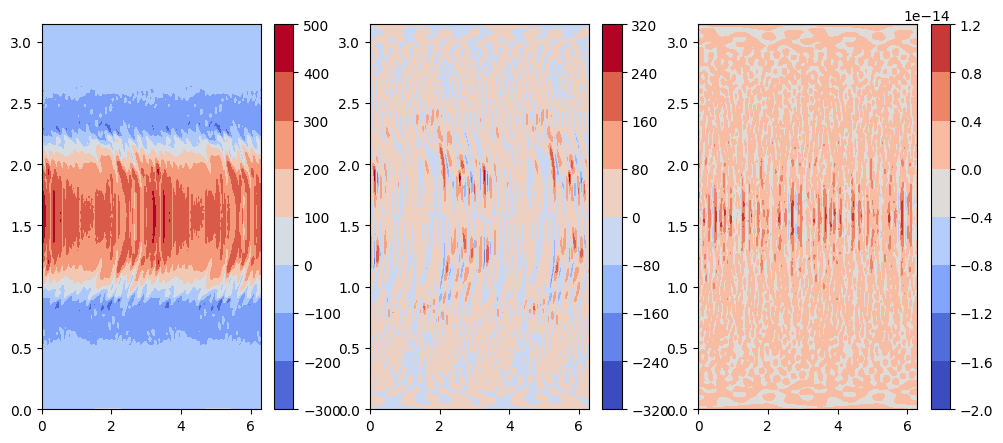

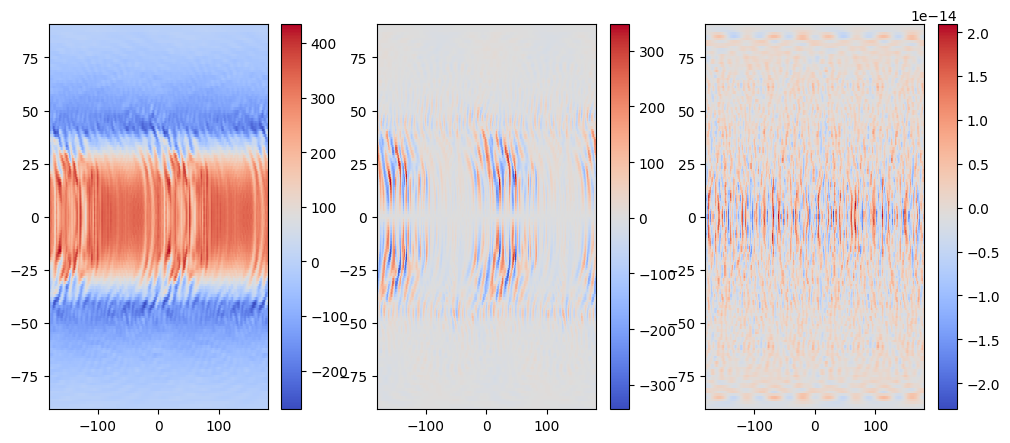

In [11]:
if __name__=="__main__":
    version_G22,endian_G22,access_G22=check_endianness('G_22.test_BIS')
    list_vel_G22,list_geo_G22,minc_G22=read_stream_G('G_22.test_BIS',endian_G22)
    vr_G22,vtheta_G22,vphi_G22=list_vel_G22[0],list_vel_G22[1],list_vel_G22[2]
    nlon_G22,nlat_G22,nr=vr_G22.shape[0],vr_G22.shape[1],vr_G22.shape[2]
    vphi_outer_G22=vphi_G22[:,:,-1]
    vtheta_outer_G22=vtheta_G22[:,:,-1]
    vr_outer_G22=vr_G22[:,:,-1]
    #print("From G_files nlon=",nlon_G22,"\t nlat=",nlat_G22)
    vphi_outer_G22,vtheta_outer_G22,vr_outer_G22=vphi_outer_G22.T,vtheta_outer_G22.T,vr_outer_G22.T
    lon_G22=np.linspace(0,2*np.pi,nlon_G22*minc_G22)
    lat_G22=np.linspace(0,np.pi,nlat_G22)
    phi_grid_G22,theta_grid_G22=np.meshgrid(lon_G22,lat_G22)
    vphi_outer_G22,vtheta_outer_G22,vr_outer_G22=np.tile(vphi_outer_G22,(1,minc_G22)),np.tile(vtheta_outer_G22,(1,minc_G22)),np.tile(vr_outer_G22,(1,minc_G22))
    vmin_vphi,vmax_vphi=vphi_outer_G22.min(),vphi_outer_G22.max()
    vmin_vtheta,vmax_vtheta=vtheta_outer_G22.min(),vtheta_outer_G22.max()
    vmin_vr,vmax_vr=vr_outer_G22.min(),vr_outer_G22.max()
    print("The output from the G files are as follows in order phi, theta and radial")
    fig,axes=plt.subplots(1,3,figsize=(12,5))
    im0=axes[0].contourf(phi_grid_G22,theta_grid_G22,vphi_outer_G22,cmap='coolwarm',vmin=vmin_vphi,vmax=vmax_vphi)
    fig.colorbar(im0, ax=axes[0], orientation='vertical')
    im1=axes[1].contourf(phi_grid_G22,theta_grid_G22,vtheta_outer_G22,cmap='coolwarm',vmin=vmin_vtheta,vmax=vmax_vtheta)
    fig.colorbar(im1, ax=axes[1], orientation='vertical')
    im2=axes[2].contourf(phi_grid_G22,theta_grid_G22,vr_outer_G22,cmap='coolwarm',vmin=vmin_vr,vmax=vmax_vr)
    fig.colorbar(im2, ax=axes[2], orientation='vertical')

    
    
    version,params,rad_sph_params,omega,rad,rho_list,potentials=read_stream('V_lmr_1000.test_BIS')
    poloidal,toroidal=potentials[0],potentials[1]
    poloidal,toroidal=poloidal[:,::-1],toroidal[:,::-1]
    print("shape of polodal field=",poloidal.shape)
    radius=rad[0]
    #contruct dpoldr to find the theta and phi components
    dpoldr=np.zeros_like(poloidal)
    dpoldr=rderavg(poloidal,radius,False)
    l_max,minc,lm_max,m_max,m_min=rad_sph_params[2],rad_sph_params[3],rad_sph_params[4],rad_sph_params[5],rad_sph_params[6]
    print("data from the potential files:\n","l_max=",l_max,"\t minc=",minc,"\t m_max=",m_max,"\t m_min=",m_min)
    n_theta=144
    print("\n n_theta max given manually =",n_theta)
    leg=Legendre(l_max,minc,n_theta,m_max,m_min)
    print(leg.lStart,leg.lStop,leg.lmOdd)
    print(leg.lStart.shape,leg.lStop.shape,leg.lmOdd.shape)
    vt,vp=leg._specspat_vec(dpoldr[:,-1],toroidal[:,-1],leg.n_theta_max,leg.n_phi_max)
    print("shape of vt=",vt.shape,"\t shape of vp=",vp.shape)
    vt=np.fft.ifft(vt,axis=0)*leg.n_phi_max#*leg.minc
    vp=np.fft.ifft(vp,axis=0)*leg.n_phi_max#*leg.minc
    vt,vp=vt.real,vp.real
    vt,vp=vt.T,vp.T

    inputLM=np.zeros_like(poloidal)
    indx,lm2l,lm2m=leg._LMmapping()
    for i in range(radius.shape[0]):
        inputLM[:,i]=poloidal[:,i]*lm2l*(lm2l+1)/radius[i]**2
    vr=leg._specspat_scal(inputLM[:,0],leg.n_theta_max,leg.n_phi_max)
    vr=np.fft.ifft(vr,axis=0)*leg.n_phi_max#*leg.minc
    vr=vr.real
    vr=vr.T
    print("shape of vr=",vr.shape)

    vt,vp,vr=np.tile(vt,(1,2)),np.tile(vp,(1,2)),np.tile(vr,(1,2))
    print("shape after tile vt =",vt.shape,"\t vp =",vp.shape,"\t vr=",vr.shape)
    nlon,nlat=vt.shape[1],vt.shape[0]
    phi_plot,theta_plot=np.linspace(0,leg.minc*np.pi,nlon),np.linspace(0,np.pi,nlat)
    phi_grid,theta_grid=np.meshgrid(phi_plot,theta_plot)
    phi_grid,theta_grid=phi_grid-np.pi,theta_grid-np.pi/2

    vmin_vp,vmax_vp=vp.min()/radius[-1],vp.max()/radius[-1]
    vmin_vt,vmax_vt=vt.min()/radius[-1],vt.max()/radius[-1]
    vmin_vr,vmax_vr=vr.min(),vr.max()

    newvp,newvt=vp/radius[-1],vt/radius[-1]
    min_index_vp,max_index_vp= np.argmin(newvp),np.argmax(newvp)
    min_coords_vp,max_coords_vp=np.unravel_index(min_index_vp,vp.shape),np.unravel_index(max_index_vp,vp.shape)
    min_index_vt,max_index_vt= np.argmin(newvt),np.argmax(newvt)
    min_coords_vt,max_coords_vt=np.unravel_index(min_index_vt,vt.shape),np.unravel_index(max_index_vt,vt.shape)
    print("For vp \n min value=",vp.min(),"\t at =",min_coords_vp,"\t max value=",vp.max(),"\t at =",max_coords_vp)
    print("For vt \n min value=",vt.min(),"\t at =",min_coords_vt,"\t max value=",vt.max(),"\t at =",max_coords_vt)
    

    fig,axes=plt.subplots(1,3,figsize=(12,5))
    im0=axes[0].pcolormesh(np.degrees(phi_grid),np.degrees(theta_grid),vp/radius[-1],shading='auto',cmap='coolwarm',vmin=vmin_vp,vmax=vmax_vp)
    fig.colorbar(im0, ax=axes[0], orientation='vertical')
    im1=axes[1].pcolormesh(np.degrees(phi_grid),np.degrees(theta_grid),vt/radius[-1],shading='auto',cmap='coolwarm',vmin=vmin_vt,vmax=vmax_vt)
    fig.colorbar(im1, ax=axes[1], orientation='vertical')
    im2=axes[2].pcolormesh(np.degrees(phi_grid),np.degrees(theta_grid),vr,shading='auto',cmap='coolwarm',vmin=vmin_vr,vmax=vmax_vr)
    fig.colorbar(im2, ax=axes[2], orientation='vertical')
    
    plt.show()

    #print("The lStart=",leg.lStart,"\n \n lStop=",leg.lStop,"\n \n lmOdd=",leg.lmOdd)
    #print("\n number of blocks=",leg.lmOdd.shape)

    #print()

    

In [12]:
if __name__=="__main__":
    version,params,rad_sph_params,omega,rad,rho_list,potentials=read_stream('V_lmr_1000.test_BIS')
    poloidal,toroidal=potentials[0],potentials[1]
    poloidal,toroidal=poloidal[:,::-1],toroidal[:,::-1]
    print("shape of polodal field=",poloidal.shape)
    radius=rad[0]
    l_max,minc,lm_max,m_max,m_min=rad_sph_params[2],rad_sph_params[3],rad_sph_params[4],rad_sph_params[5],rad_sph_params[6]
    print("data from the potential files:\n","l_max=",l_max,"\t minc=",minc,"\t m_max=",m_max,"\t m_min=",m_min)
    n_theta=144
    print("\n n_theta max given manually =",n_theta)
    leg=Legendre(l_max,minc,n_theta,m_max,m_min)
    l_list_outer,Eltot_outer,Elphi_outer,Elthe_outer,Elrad_outer=leg._spectra(radius,'outer',poloidal,toroidal,1,None)
    m_list_outer,Emtot_outer,Emphi_outer,Emthe_outer,Emrad_outer=leg._spectra(radius,'outer',poloidal,toroidal,None,1)
    l_list_inner,Eltot_inner,Elphi_inner,Elthe_inner,Elrad_inner=leg._spectra(radius,'inner',poloidal,toroidal,1,None)
    m_list_inner,Emtot_inner,Emphi_inner,Emthe_inner,Emrad_inner=leg._spectra(radius,'inner',poloidal,toroidal,None,1)

time from potential file= 0.9499
shape of polodal field= (2401, 97)
data from the potential files:
 l_max= 96 	 minc= 2 	 m_max= 96 	 m_min= 0

 n_theta max given manually = 144
inside matder
inside matder
inside matder
inside matder


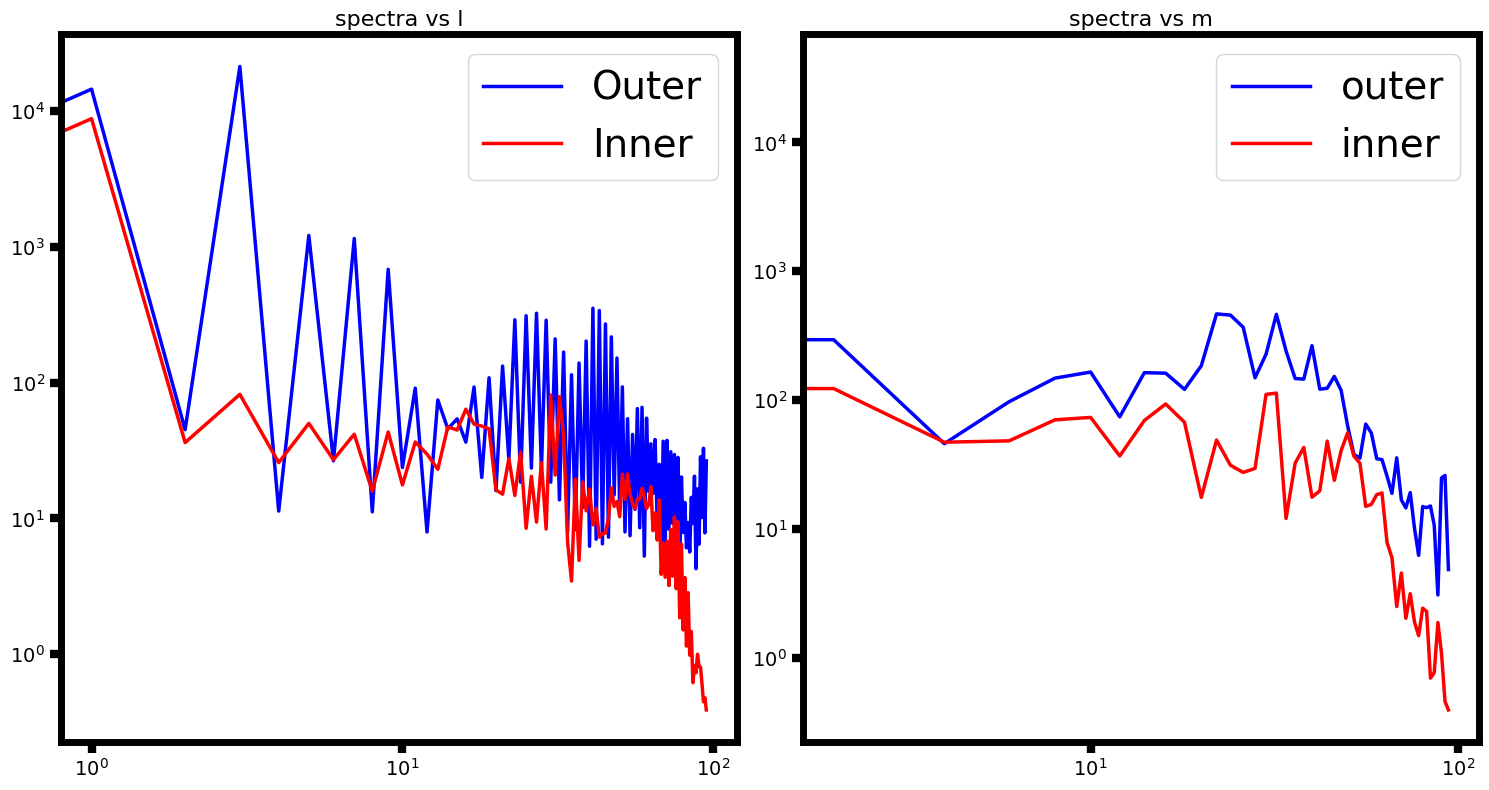

In [13]:
#Em,Emt,Emp,Emr,m_list=np.array(Em),np.array(Emt),np.array(Emp),np.array(Emr),np.array(m_list)
#El,Elt,Elp,Elr,l_list=np.array(El),np.array(Elt),np.array(Elp),np.array(Elr),np.array(l_list)
    #plt.loglog(m_list,Em,'k-',m_list,Emp,'r-',m_list,Emt,'g-')
    #plt.loglog(l_list,El,'k--',l_list,Elp,'r--',l_list,Elt,'g--')
    #plt.legend(['E','Ep','Et'])
    #plt.loglog(m_list,Em,'k-',m_list,Emp,'r-',m_list,Emt,'g-',m_list,Emr,'b-')
    #plt.legend(['E','Ep','Et','Er'])
width_tick_params,length_tick_params=6,8
spine_width=5
l_list_outer,Eltot_outer,l_list_inner,Eltot_inner=np.array(l_list_outer),np.array(Eltot_outer),np.array(l_list_inner),np.array(Eltot_inner)
m_list_outer,Emtot_outer,m_list_inner,Emtot_inner=np.array(m_list_outer),np.array(Emtot_outer),np.array(m_list_inner),np.array(Emtot_inner)
fig,axes=plt.subplots(1,2,figsize=(15,8))
axes[0].loglog(l_list_outer,Eltot_outer,'b-',l_list_inner,Eltot_inner,'r-',lw=2.5)
axes[0].set_title("spectra vs l",fontsize=16)
axes[0].legend(['Outer','Inner'],fontsize=28)

axes[1].loglog(m_list_outer,Emtot_outer,'b-',m_list_inner,Emtot_inner,'r-',lw=2.5)
axes[1].set_title("spectra vs m",fontsize=16)
axes[1].legend(['outer','inner'],fontsize=28)

    
    #axes[0].loglog(l_list,El,l_list,Elp,l_list,Elt,l_list,Elr,lw=2.5)
    #axes[0].set_title("spectra vs l",fontsize=16)
    #axes[0].legend(['E','Ep','Et','Er'],fontsize=28)

    #axes[1].loglog(m_list,Em,m_list,Emp,m_list,Emt,m_list,Emr,lw=2.5)
    #axes[1].set_title("spectra vs m",fontsize=16)
    #axes[1].legend(['E','Ep','Et','Er'],fontsize=28)

for ax in axes:
    ax.tick_params(axis='both', labelsize=14,width=width_tick_params,length=length_tick_params)
    for spine in ax.spines.values():
        spine.set_linewidth(spine_width)

plt.tight_layout()
plt.show()

In [14]:
#if __name__=="__main__":
    #version_G22,endian_G22,access_G22=check_endianness('G_22.test_BIS')
    #list_vel_G22,list_geo_G22,minc_G22=read_stream_G('G_22.test_BIS',endian_G22)
    #vr_G22,vtheta_G22,vphi_G22=list_vel_G22[0],list_vel_G22[1],list_vel_G22[2]
    #nlon_G22,nlat_G22,nr=vr_G22.shape[0],vr_G22.shape[1],vr_G22.shape[2]
    #vphi_outer_G22=vphi_G22[:,:,-1]
    #vtheta_outer_G22=vtheta_G22[:,:,-1]
    #vr_outer_G22=vr_G22[:,:,-1]
    ##print("From G_files nlon=",nlon_G22,"\t nlat=",nlat_G22)
    #vphi_outer_G22,vtheta_outer_G22,vr_outer_G22=vphi_outer_G22.T,vtheta_outer_G22.T,vr_outer_G22.T
    #lon_G22=np.linspace(0,2*np.pi,nlon_G22*minc_G22)
    #lat_G22=np.linspace(0,np.pi,nlat_G22)
    #phi_grid_G22,theta_grid_G22=np.meshgrid(lon_G22,lat_G22)
    #vphi_outer_G22,vtheta_outer_G22,vr_outer_G22=np.tile(vphi_outer_G22,(1,minc_G22)),np.tile(vtheta_outer_G22,(1,minc_G22)),np.tile(vr_outer_G22,(1,minc_G22))
    #vmin_vphi,vmax_vphi=vphi_outer_G22.min(),vphi_outer_G22.max()
    #vmin_vtheta,vmax_vtheta=vtheta_outer_G22.min(),vtheta_outer_G22.max()
    #vmin_vr,vmax_vr=vr_outer_G22.min(),vr_outer_G22.max()
    #print("The output from the G files are as follows in order phi, theta and radial")
    #fig,axes=plt.subplots(1,3,figsize=(12,5))
    #im0=axes[0].contourf(phi_grid_G22,theta_grid_G22,vphi_outer_G22,cmap='coolwarm',vmin=vmin_vphi,vmax=vmax_vphi)
    #fig.colorbar(im0, ax=axes[0], orientation='vertical')
    #im1=axes[1].contourf(phi_grid_G22,theta_grid_G22,vtheta_outer_G22,cmap='coolwarm',vmin=vmin_vtheta,vmax=vmax_vtheta)
    #fig.colorbar(im1, ax=axes[1], orientation='vertical')
    #version,params,rad_sph_params,omega,rad,rho_list,potentials=read_stream('V_lmr_1000.test_BIS')
    
    #poloidal,toroidal=potentials[0],potentials[1]
    #print(poloidal.shape)
    #radius=rad[0]
    ##contruct dpoldr to find the theta and phi components
    #dpoldr=np.zeros_like(poloidal)
    #dpoldr=rderavg(poloidal,radius,False)
    #l_max,minc,lm_max,m_max,m_min=rad_sph_params[2],rad_sph_params[3],rad_sph_params[4],rad_sph_params[5],rad_sph_params[6]
    #print("data from the potential files:\n","l_max=",l_max,"\t minc=",minc,"\t m_max=",m_max)
    #n_theta=144
    #print("\n n_theta max given manually =",n_theta)
    #leg=Legendre(l_max,minc,n_theta,m_max,m_min)
    #print(leg.lStart,leg.lStop,leg.lmOdd)
    #print(leg.lStart.shape,leg.lStop.shape,leg.lmOdd.shape)
    #vt,vp=leg._specspat_vec(dpoldr[:,0],toroidal[:,0],leg.n_theta_max,leg.n_phi_max)
    #print("shape of vt=",vt.shape,"\t shape of vp=",vp.shape)
    #vt=np.fft.ifft(vt,axis=0)*leg.n_phi_max#*leg.minc
    #vp=np.fft.ifft(vp,axis=0)*leg.n_phi_max#*leg.minc
    #vt,vp=vt.real,vp.real
    #vt,vp=vt.T,vp.T

    #vt,vp=np.tile(vt,(1,2)),np.tile(vp,(1,2))
    #nlon,nlat=vt.shape[1],vt.shape[0]
    #phi_plot,theta_plot=np.linspace(0,leg.minc*np.pi,nlon),np.linspace(0,np.pi,nlat)
    #phi_grid,theta_grid=np.meshgrid(phi_plot,theta_plot)
    #phi_grid,theta_grid=phi_grid-np.pi,theta_grid-np.pi/2

    #vmin_vp,vmax_vp=vp.min(),vp.max()
    #vmin_vt,vmax_vt=vt.min(),vt.max()

    #fig,axes=plt.subplots(1,3,figsize=(12,5))
    #im0=axes[0].pcolormesh(np.degrees(phi_grid),np.degrees(theta_grid),vp,shading='auto',cmap='coolwarm',vmin=vmin_vp,vmax=vmax_vp)
    #fig.colorbar(im0, ax=axes[0], orientation='vertical')
    #im1=axes[1].pcolormesh(np.degrees(phi_grid),np.degrees(theta_grid),vt,shading='auto',cmap='coolwarm',vmin=vmin_vt,vmax=vmax_vt)
    #fig.colorbar(im1, ax=axes[1], orientation='vertical')

    

    
    #plt.show()

    #print("The lStart=",leg.lStart,"\n \n lStop=",leg.lStop,"\n \n lmOdd=",leg.lmOdd)
    #print("\n number of blocks=",leg.lmOdd.shape)

    #print()